<!--HEADER-->
[*Notas sobre modelagem da epidemia de Covid-19*](https://github.com/rmsrosa/modcovid19) / [*IM-UFRJ*](https://www.im.ufrj.br).

# O cenário da cidade do Rio de Janeiro: rede escolar

- Continuando a criação de cenários que sejam **múltiplos** do cenário `Pop350` visto anteriormente.

- Neste segundo caderno da série, ...

In [1]:
import datetime # date and time tools

import os, sys

import math

import random

import numpy as np
from scipy import stats

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

import io, base64
from IPython.display import Image, HTML

import pandas as pd

import rede_escolar

/Users/macbookpro/anaconda3/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../../..')))
import episiming

In [3]:
sns.set_style("darkgrid")

In [4]:
dt_string = datetime.datetime.now().strftime("%d/%b/%Y")
print(f"Atualização mais recente do kernel: {dt_string}")

Atualização mais recente do kernel: 29/Jun/2020


## Distribuição populacional da cidade do Rio de Janeiro

Primeiramente, conforme feito anteriormente:

- posicionamos as residências;

- distribuímos os indivíduos em suas residências; e 

- posicionamos os indivíduos em torno de suas residências.

### Carregando os dados

Carregamos os dados populacionais por quilômetro quadrado da cidade do Rio de Janeiro obtidos do [Landscan](https://landscan.ornl.gov), mudando para 0 o valor das células com -1.

In [5]:
landscan_rio = np.load('../../../../dados/RJ/cidade_rj/dados_estatisticos/LandScan.npy').astype(int)
landscan_rio = np.maximum(landscan_rio, 0)

Carregamos os dados de escolas por quilômetro quadrado da cidade do Rio de Janeiro, obtidos do [IPP/Data Rio](https://www.data.rio/datasets/escolas-municipais)

In [6]:
escolas_municipais = np.load('../../../../dados/RJ/cidade_rj/dados_estatisticos/Municipais.npy').astype(int)

### Visualização em escala logarítmica

Visualizamos 

$$ ln( 1 + \textrm{população})
$$

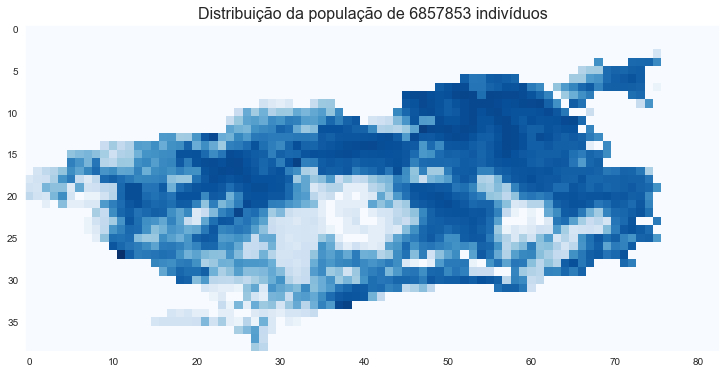

In [7]:
plt.figure(figsize=(16,6))
plt.imshow(np.log(1 + landscan_rio), cmap='Blues', interpolation='none')
plt.grid(False)
plt.title(f'Distribuição da população de {int(landscan_rio.sum())} indivíduos', fontsize=16)
plt.show()

## Rede residencial

Montamos a rede residencial como antes.

O importante para a montagem da rede de empresas não é a rede residencial em si, apenas a localização dos indivíduos feita na construção da rede residencial.

### Reduzindo a população

Com o objetivo de realizar testes mais rápidos, com populações menores, dividimos a população de cada bloco por um determinado fator. 

Essa divisão nos dá números em ponto flutuante, que então truncamos para a sua parte inteira.

In [8]:
censo_residencial = np.array([.21, .26, .20, .17, .08, .04, .02, 0.02])
pop_por_blocos = (landscan_rio/100).astype(int)

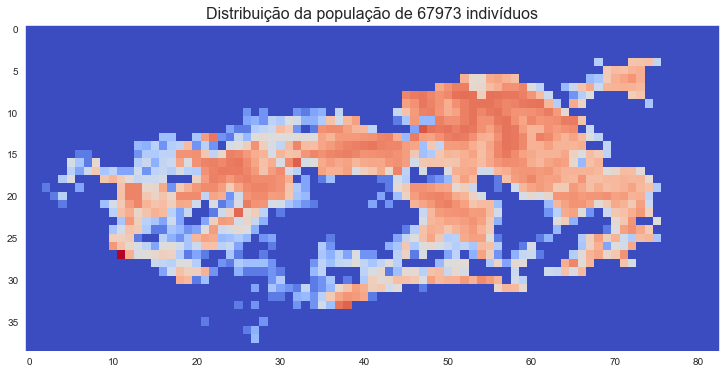

In [9]:
plt.figure(figsize=(16,6))
plt.imshow(np.log(1 + pop_por_blocos), cmap='coolwarm', interpolation='none')
#plt.colorbar()
plt.grid(False)
plt.title(f'Distribuição da população de {pop_por_blocos.sum()} indivíduos', fontsize=16)
plt.show()

### Distribuindo e alocando os indivíduos e as suas residências

In [10]:
%%time
pos_residencias, pos_individuos, res_individuos, pop_blocos_indices \
    = episiming.cenarios.aloca_residencias_e_individuos(pop_por_blocos, censo_residencial)

CPU times: user 1.05 s, sys: 17.4 ms, total: 1.07 s
Wall time: 1.09 s


In [11]:
pop_blocos_indices[-1]

67973

### Gerando o grafo da rede residencial

In [12]:
%%time
attrib_pos_individuos = {j: pos_individuos[j] for j in range(len(pos_individuos))}

G_r = nx.random_geometric_graph(len(pop_por_blocos), 0, pos=attrib_pos_individuos)

for individuos in res_individuos:
    if len(individuos) > 1:
        G_r.add_edges_from([(i,j) for i in individuos for j in individuos if i < j])

CPU times: user 426 ms, sys: 27.6 ms, total: 454 ms
Wall time: 474 ms


### Viualização

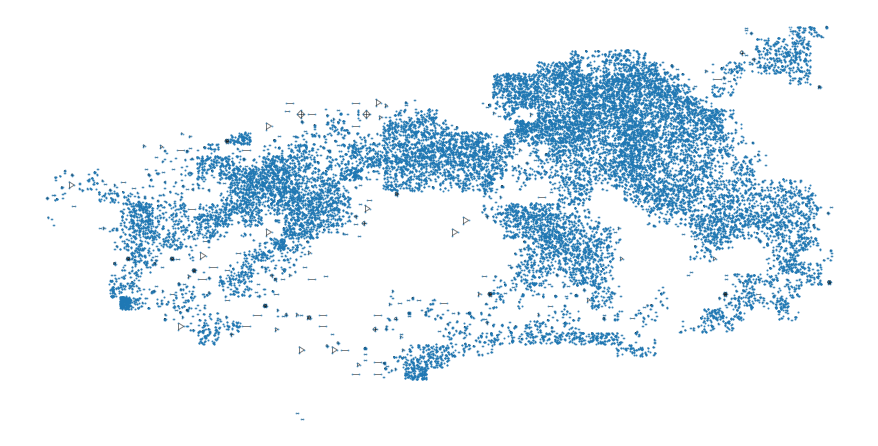

CPU times: user 2.48 s, sys: 112 ms, total: 2.59 s
Wall time: 2.46 s


In [13]:
%%time
plt.figure(figsize=(12,6))
nx.draw(G_r, pos=attrib_pos_individuos, node_size=1, alpha=0.5)
plt.show()

## Rede escolar

Na construção da rede escolar, a ideia é fazer os seguintes passos:

- Temos as distribuições geolocalizadas das escolas.

- A partir do censo de idade populacional, determinar a parte da população a ser alocada nas escolas

- Para alocar a população nas escolas: Calculamos a distância de cada individuo para todas as escolas, e tomamos as 3 escolas mais próximas. Feito isso é selecionao uma das 3 escolas de maneira aleatória

- Para o cenário múltiplo de `Pop350`, fazemos uma redução proporcional no número de escolas com a função `random.choices`

### Redução no número de escolas

Para acompanhar a redução na população, fazemos uma redução proporcional no número de escolas

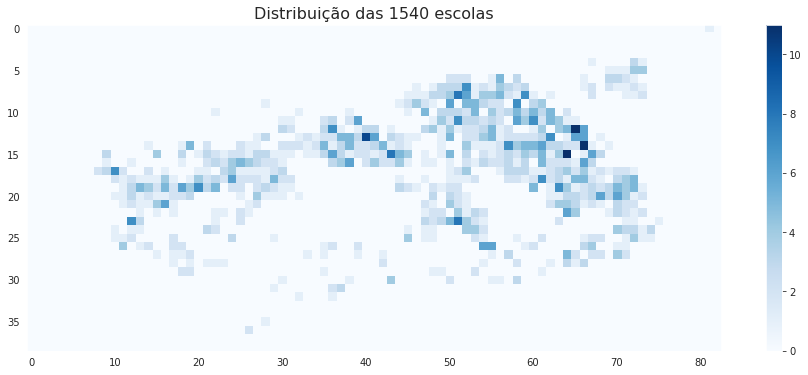

In [14]:
plt.figure(figsize=(16,6))
plt.imshow(escolas_municipais, cmap='Blues', interpolation='none')
plt.colorbar()
plt.grid(False)
plt.title(f'Distribuição das {escolas_municipais.sum()} escolas', fontsize=16)
plt.show()

In [15]:
tx_reducao = 100
esc_escolha, dist_escolas = rede_escolar.distribui_escolas(tx_reducao, escolas_municipais)

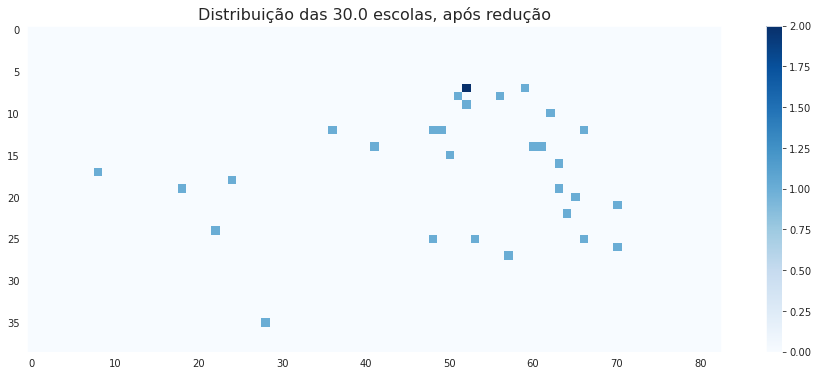

In [16]:
plt.figure(figsize=(16,6))
plt.imshow(dist_escolas, cmap='Blues', interpolation='none')
plt.colorbar()
plt.grid(False)
plt.title(f'Distribuição das {dist_escolas.sum()} escolas, após redução', fontsize=16)
plt.show()

## Distribuição das idades

## Pirâmide etária do rio de Janeiro

- Como as pirâmides etárias do Rio de Janeiro e do Brasil são razoavelmente diferentes, vamos trabalhar com os dados do Rio.

- Inicialmente, consideramos a pirâmide populacional da cidade do Rio de Janeiro disponível na [Tabela do IPP/Data Rio](https://www.data.rio/datasets/popula%C3%A7%C3%A3o-residente-por-grupos-de-idade-e-sexo-segundo-as-%C3%A1reas-de-planejamento-ap-e-regi%C3%B5es-administrativas-ra-no-munic%C3%ADpio-do-rio-de-janeiro-2010)

In [17]:
num_pop = pop_por_blocos.sum()

piramide_etaria = pd.read_csv('../../../../dados/RJ/cidade_rj/dados_estatisticos/piramide_etaria_MRJ.csv')
idades_grupos = np.array([int(p[0:2]) for p in piramide_etaria.columns[1:]])
idades_grupos[-1] = 100
idades_fracoes_grupos = piramide_etaria.iloc[0][1:].values/piramide_etaria.iloc[0][0]

idade_max = 100
pop_idades = episiming.cenarios.gera_idades(67973, 8, res_individuos, idades_grupos, idades_fracoes_grupos, idade_max = 100)

/home/gil/repos/covid19/episiming/cenarios.py:232: RuntimeWarning: divide by zero encountered in double_scalars
  * [idades_fracoes_grupos[-1]/(idade_max-idades_grupos[-1])]


In [18]:
dist_idades_na_escola = rede_escolar.distribuicao_idade(num_pop, censo_residencial, res_individuos, pop_idades, piramide_etaria, idades_grupos, idades_fracoes_grupos, idade_max)

### Escolhendo os alunos

In [27]:
alunos = rede_escolar.escolhe_alunos_idade(pop_idades, dist_idades_na_escola)

## Alocando população escolar nas escolas

### Gerando a localização das escolas

In [26]:
escolas = rede_escolar.aloca_alunos(alunos, esc_escolha, pos_individuos)

## Criando a rede

In [28]:
G_esc = rede_escolar.gera_rede_escolar(num_pop, attrib_pos_individuos, escolas)

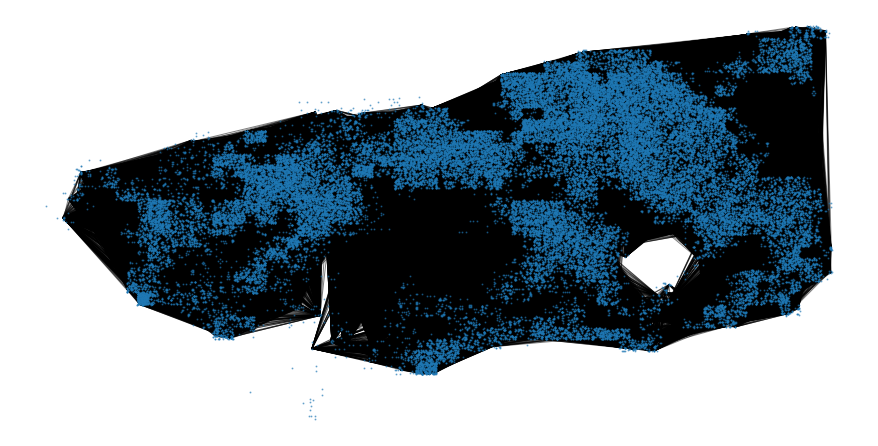

In [29]:
plt.figure(figsize=(12,6))
nx.draw(G_esc, pos=attrib_pos_individuos, node_size=1, alpha=0.5)
plt.show()

---